In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pcsp
from pcsp import PCSPipeline, ModuleSet, Module, init_args
from pcsp.pipeline import build_graph
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.utils
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from irf import irf_utils, irf_jupyter_utils
from irf.irf_utils import run_iRF
from irf.ensemble import RandomForestClassifierWithWeights
from sklearn.inspection import permutation_importance

permutation_importance() missing 1 required positional argument: 'y'
permutation_importance() missing 1 required positional argument: 'y'
permutation_importance() missing 1 required positional argument: 'y'
/Users/rush/Desktop/binyugroup/pcs-pipeline/pcsp/pipeline.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


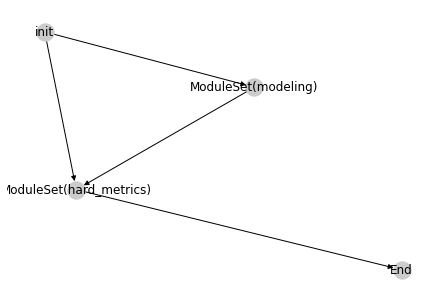

{(('X_train', 'y_train', 'subsampling_0', 'RF', 'X_test'),
  'y_test',
  'Acc'): 0.9260969976905312,
 (('X_train', 'y_train', 'subsampling_0', 'RF', 'X_test'),
  'y_test',
  'Bal_Acc'): 0.8265151515151515,
 (('X_train', 'y_train', 'subsampling_1', 'RF', 'X_test'),
  'y_test',
  'Acc'): 0.9245573518090839,
 (('X_train', 'y_train', 'subsampling_1', 'RF', 'X_test'),
  'y_test',
  'Bal_Acc'): 0.7941719993756828,
 (('X_train', 'y_train', 'subsampling_2', 'RF', 'X_test'),
  'y_test',
  'Acc'): 0.9240441365152682,
 (('X_train', 'y_train', 'subsampling_2', 'RF', 'X_test'),
  'y_test',
  'Bal_Acc'): 0.8070601570723018,
 '__prev__': <pcsp.module_set.ModuleSet at 0x7fa0d32990b8>}

In [18]:
# load data
X_train = np.asarray(pd.read_csv("./data/01_X_train.csv",error_bad_lines=False).iloc[:,1:])
X_test = np.asarray(pd.read_csv("./data/02_X_test.csv",error_bad_lines=False).iloc[:,1:])
y_train = np.asarray(pd.read_csv("./data/03_y_train.csv",error_bad_lines=False).iloc[:,1])
y_test = np.asarray(pd.read_csv("./data/04_y_test.csv",error_bad_lines=False).iloc[:,1])

rf = RandomForestClassifier(n_estimators=100, max_depth=5).fit(X_train, y_train)
# initialize data
np.random.seed(14)
X_train, X_test, y_train, y_test = init_args((X_train, X_test, y_train, y_test), names=['X_train', 'X_test', 'y_train', 'y_test'])

# subsample
subsampling_fns = [partial(sklearn.utils.resample, n_samples=1000, random_state=i) for i in range(3)]

subsampling_set = ModuleSet(name='subsampling', modules=subsampling_fns)
X_trains, y_trains = subsampling_set(X_train, y_train)

modeling_set = ModuleSet(name='modeling', modules=[RandomForestClassifier(n_estimators=50, max_depth=5)], module_keys=["RF"])

# model
modeling_set.fit(X_trains, y_trains)
preds = modeling_set.predict(X_test)

# hard metrics
hard_metrics_set = ModuleSet(name='hard_metrics', modules=[accuracy_score, balanced_accuracy_score], module_keys=["Acc", "Bal_Acc"])
hard_metrics = hard_metrics_set.evaluate(preds, y_test)

# permutation importance
feature_importance_set = ModuleSet(name='feature_importance', modules=[permutation_importance])
importances = feature_importance_set.evaluate(modeling_set.out, X_test, y_test)

G = build_graph(hard_metrics, draw=True)
plt.show()
hard_metrics

In [3]:
print({k:np.argsort(v.importances_mean)[-5:][::-1] for (k, v) in importances.items() if type(v) != pcsp.module_set.ModuleSet})

{}


In [8]:
print(modeling_set.out.keys())
print(X_test.keys())
print(y_test.keys())

dict_keys([('X_train', 'y_train', 'subsampling_0', 'RF'), ('X_train', 'y_train', 'subsampling_1', 'RF'), ('X_train', 'y_train', 'subsampling_2', 'RF'), '__prev__'])
dict_keys(['X_test', '__prev__'])
dict_keys(['y_test', '__prev__'])
